# Meta-Learning

In [0]:
from IPython.display import Image

import sys

!test -d neural_processes || git clone https://github.com/JTT94/neural_processes.git
if not 'neural_processes' in sys.path:
  sys.path.append('neural_processes')
  
from src.neuralprocesses import NeuralProcessParams, split_context_target
from src.neuralprocesses.network import encoder_h, decoder_g, xy_to_z_params
from src.neuralprocesses.process import init_neural_process
from src.neuralprocesses.predict import posterior_predict
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf

Cloning into 'neural_processes'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 482 (delta 76), reused 88 (delta 55), pack-reused 346
Receiving objects: 100% (482/482), 37.57 MiB | 30.77 MiB/s, done.
Resolving deltas: 100% (214/214), done.


## Introduction

Neural networks (NN) are used to parameterise a single function (task) using a large number of training points. Due  to the often high-dimensionality of performant neural networks, it may take significant time and computation to train each NN for each task. This difficulty is exacerbated if there are many tasks as it can be impractical to train multiple similar networks. Meta-learning addresses this limitation by constructing procedures for "learning to learn", i.e. choosing the network training process so that it can perform well on multiple tasks and adapt quickly to learn new tasks. In this project we explored two approaches to meta-learning: Neural Processes (NPs) and the Model-Agnostic Meta-Learning (MAML) procedure. 

This report first details the theory behind the methods, then details implementations on several examples, using different classes of functions.

# Theory

## Neural Processes

### Neural Processes (NPs)

[Neural Processes](https://arxiv.org/abs/1807.01622) (NPs) can be viewed as a class of probabilistic models based on Neural Networks (NNs), which can represent distributions over stochastic processes. They combine the advantages of NNs, being computationally efficient, with those of Gaussian Processes (GPs), being data-efficient and flexible. The result can be seen as a prior over functions (or tasks). 

Unlike in the training of canonical multi-layer perceptrons observation, during the training of Neural Processes, the training set $O = \{(x_i, y_i)\}_{i=1}^n$, is used to form a set of context points $C = \{(x_j, y_j), j = 1, ..., m\}$ and a set of target points $T = \{ (x^*_k, y^*_k), k = m+1, ..., n \}$. Given the context set and the $x^*_k$, the goal is to predict the function values $y^*_k$.  In the forward pass, latent variable $z$ is sampled using the context set then the output is sampled using $z$ and  $x^*_k$ from the target set. The loss is computed using the sampled output from the last step and and $y^*_k$ from the target data set. This loss is then used in gradient descent and back-propagation. This utility of splitting the training data into context and target sets is to improve generalisation over the trained networks.

NPs can be seen as latent variable models that capture the hidden distributions among the tasks. We denote these probabilistic latent representations by $z$ and their distribution by $p(z|x_{1:m}, y_{1:m})$. In practice this is unknown and is approximated using a Gaussian distribution for convenience, similar to variational autoencoders. 

The Neural Processes model and training procedure is well illustrated by the figure from [Kaspar Martens' tutorial on Neural Processes](https://kasparmartens.rbind.io/post/np/),

![](https://raw.githubusercontent.com/kasparmartens/NeuralProcesses/master/fig/schema2.png)

Starting from the first step of the algorthim, we have:

1. The context set $\{x_i, y_i\}_{i=1}^m$ is first mapped through the R-encoder $h$, usually a neural network, to obtain the latent representations $\{r_i\}_{i=1}^m$. 

2. These latent representations are then aggregated in a permutation invariant manner, usually done by taking averages, to produce a single vector $r$.

3. This $r$ is then passed to two other neural networks to produce the parameters $\mu_z$ and $\sigma_z$ of the approximated gaussian distribution of $z$.

4. Finally, we sample a $z$ from the distribution and concantanate it with the input target $x^{*}$. This is then passed to the decoder neural network $g$ to obtain a prediction of $y^*$.

The optimisation criterion for this layout is the evidencce lower-bound of posterior predictive density, 
$$
\log p(y^*_{m+1:n}|x_{1:m}, y_{1:m}) \geq \mathbb{E}_{q(z|x_{1:n}, y_{1:n})} \bigg[ \sum_{i=m+1}^n \log p(y_i|z, x_i) + \log \frac{q(z|x_{1:m}, y_{1:m})}{q(z|x_{1:n}, y_{1:n})}\bigg]
$$
which is an approximated version as we have no access to $p(z|x_{1:m}, y_{1:m})$.

Note that the parameters of $z$ are estimated using only the context points $\{x_i, y_i\}_{i=1}^m$, but the ELBO is calculated with respect to both the target and the context points.  At prediction time, samples are taken from $z \sim \mathcal{N}(\mu_z,\sigma_z^2)$ and passed through the decoder $g$ with the values of $x$ from the target set.

-----------------------

### We will now demonstrate this idea on a simple 1-D regression case.

Let's first sample a single function from a GP with the following kernel,

$$
k(x, x') = \sigma\exp\big(-\frac{||x-x'||^2}{2l^2}\big)
$$

where we set the noise $\sigma$ and the lengthscale $l$ to be 1,



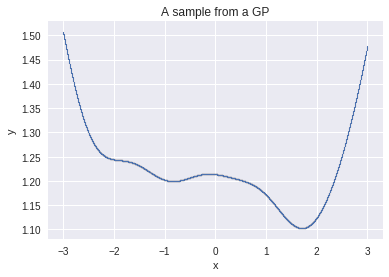

Picking different number of points from the function to run the NP alogorithm


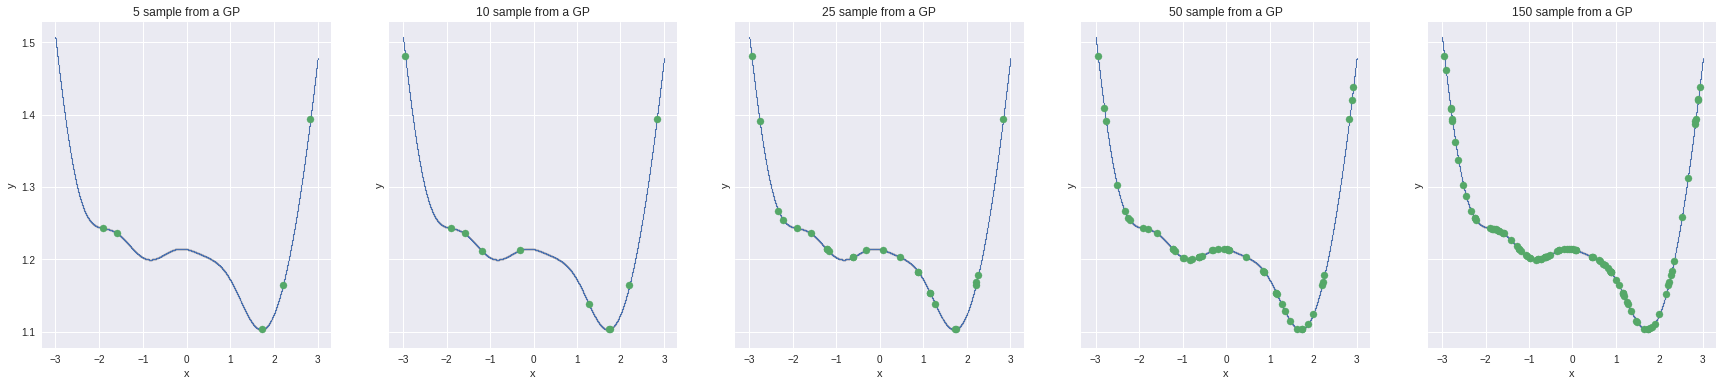

In [0]:
# Load the image
display(Image('../content/neural_processes/experiments/Alan/1sample_GP.png'))
print("Picking different number of points from the function to run the NP alogorithm")
display(Image('../content/neural_processes/experiments/Alan/context_points.png', width = 1200))


We will now run the NP algorithm to the above datasets. We will set both the dimension of $r$ and $z$ to be 1. From left to right, we see the progression of the algorithm against the number of iterations.  

For 5 data points


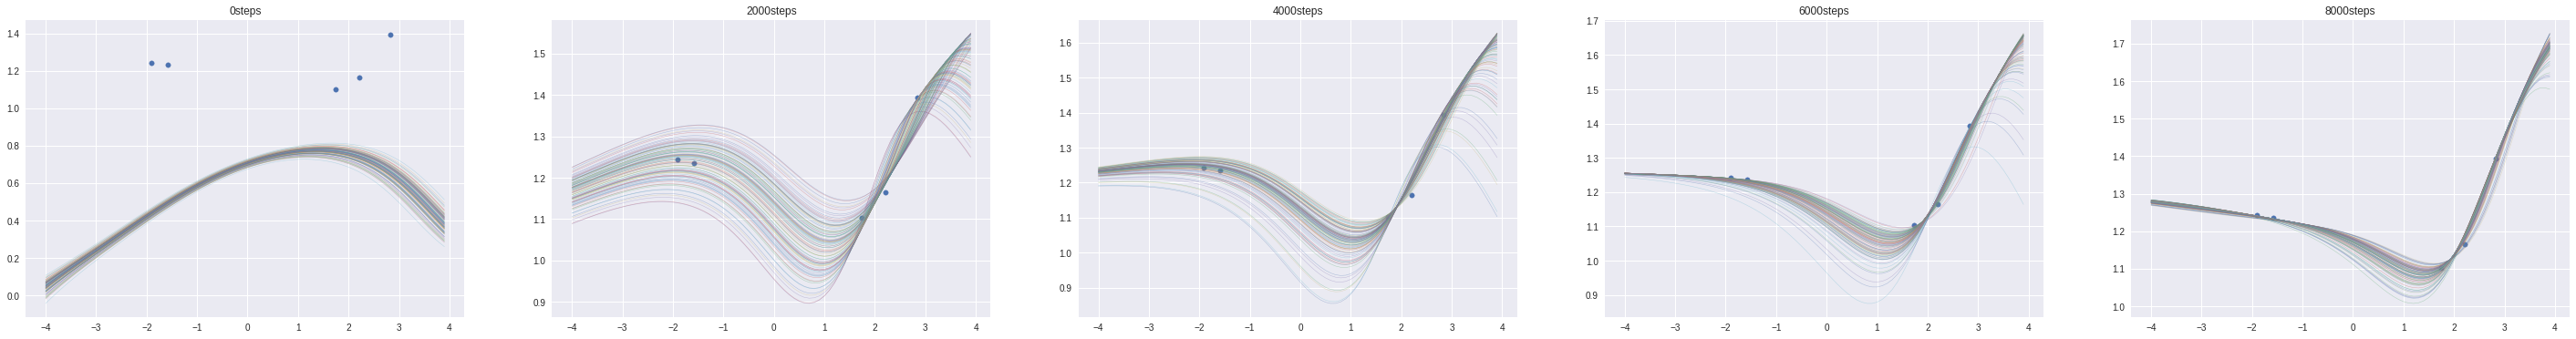

For 10 data points


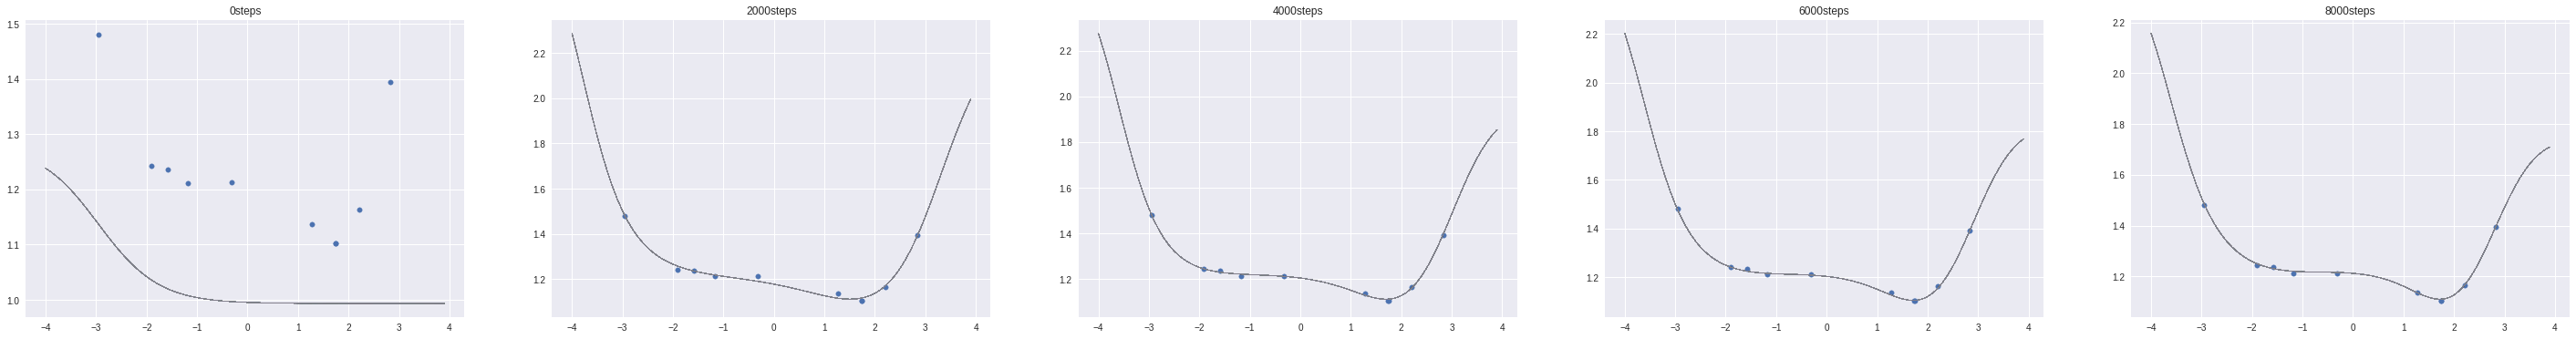

For 25 data points


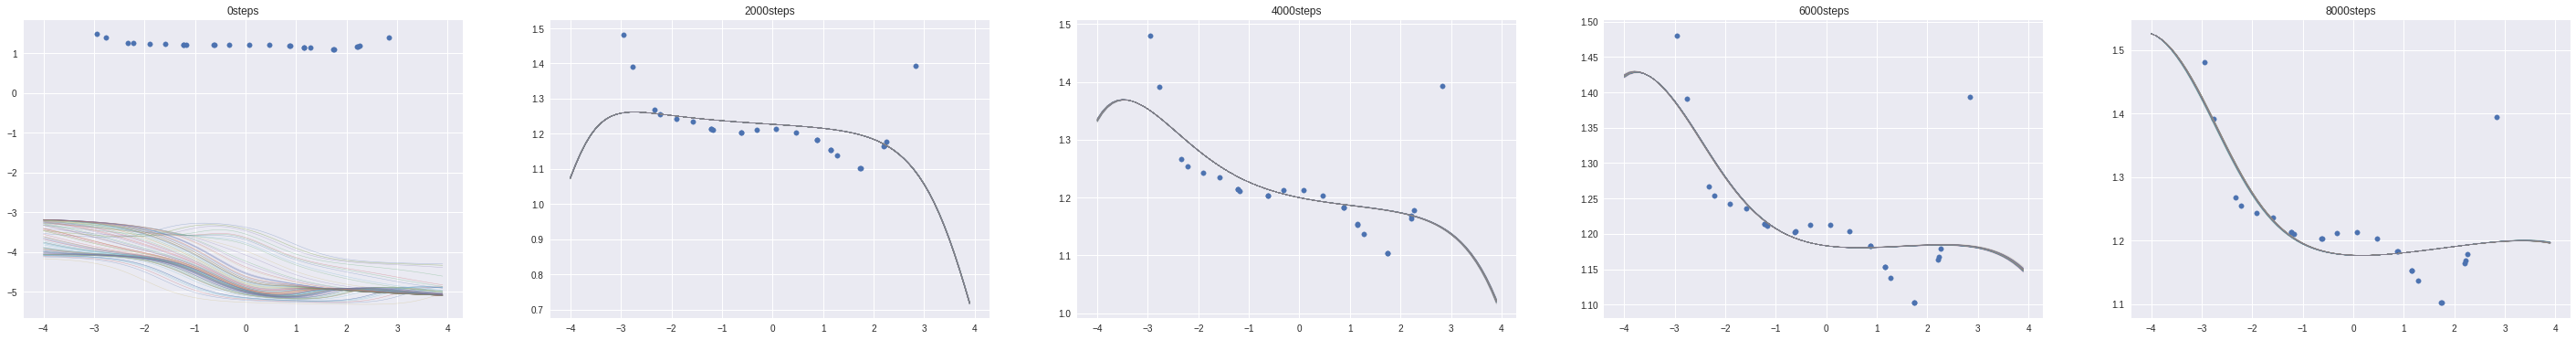

For 50 data points


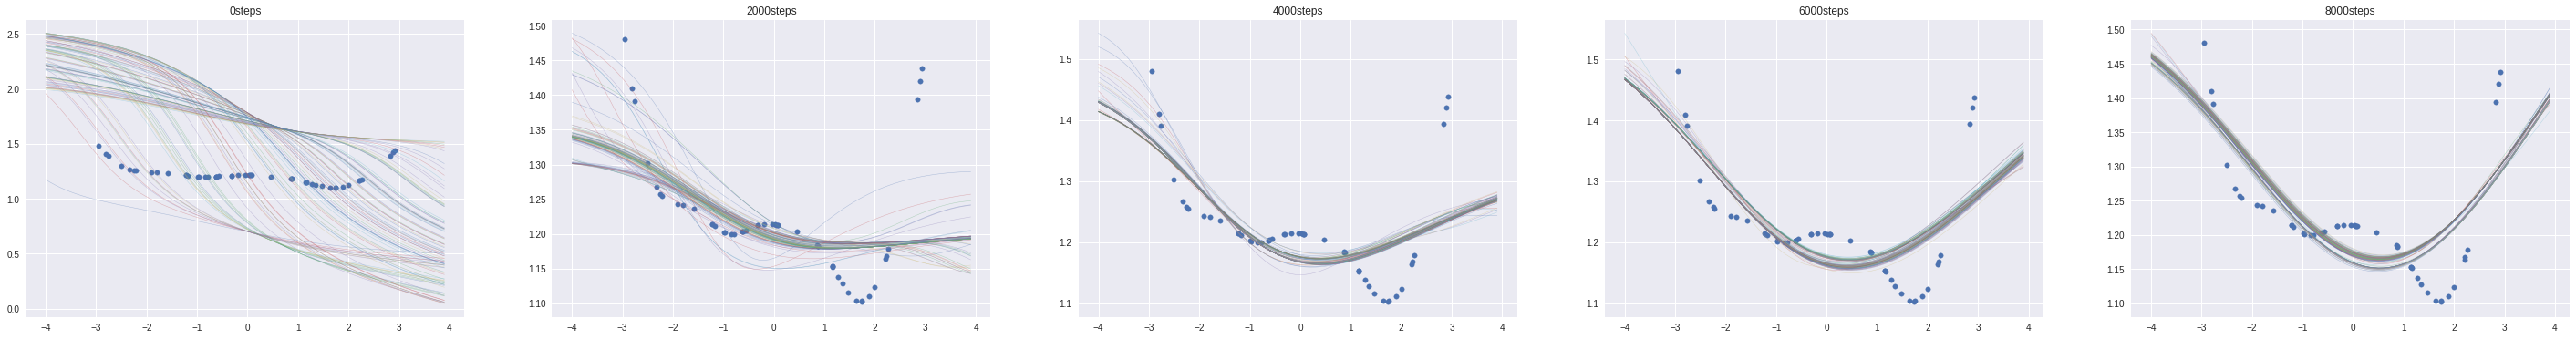

For 150 data points


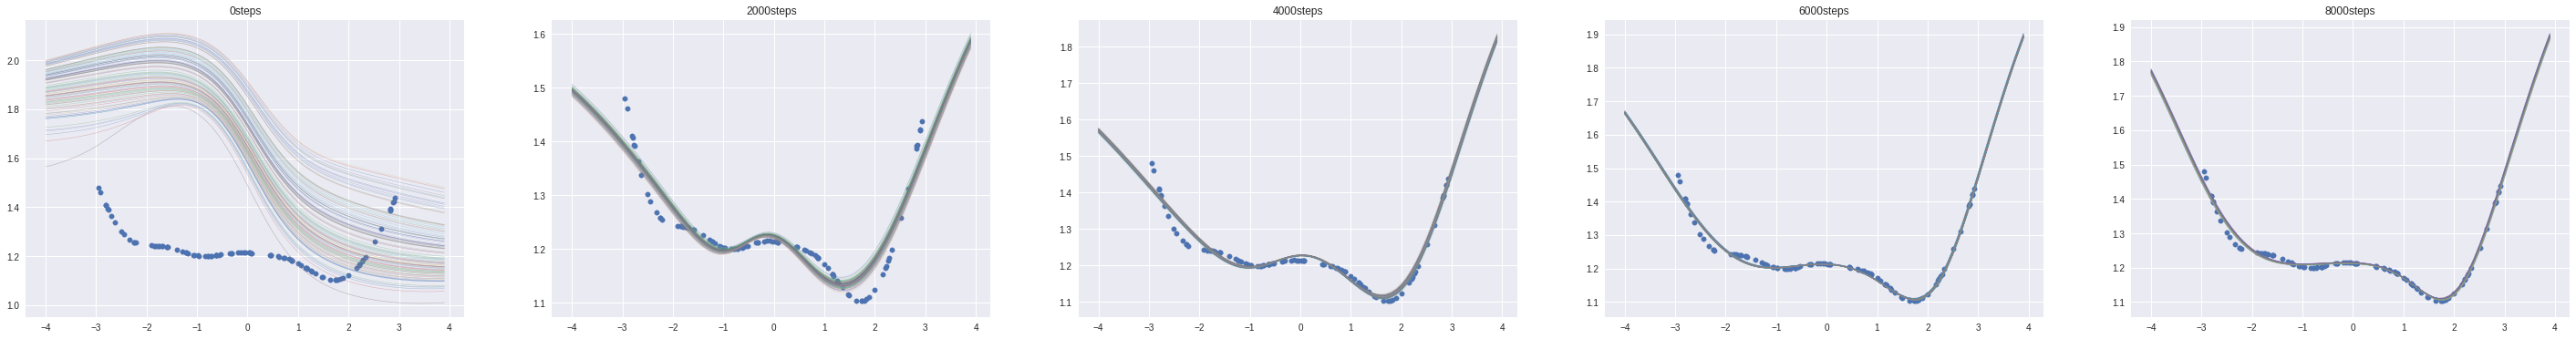

In [0]:
print("For 5 data points")
display(Image("../content/neural_processes/experiments/Alan/5 samples.png", width=1200, height=200))
print("For 10 data points")
display(Image("../content/neural_processes/experiments/Alan/10 samples.png", width=1200, height=200))
print("For 25 data points")
display(Image("../content/neural_processes/experiments/Alan/25.png", width=1200, height=200))
print("For 50 data points")
display(Image("../content/neural_processes/experiments/Alan/50 samples.png", width=1200, height=200))
print("For 150 data points")
display(Image("../content/neural_processes/experiments/Alan/150 samples.png", width=1200, height=200))


### Conditional Neural Processes (CNPs)

[Conditional Neural Processes](https://arxiv.org/abs/1807.01613) (CNPs) are similar to NPs, but lack the stochastic global latent variable $z$. There is a deterministic connection between the context and target sets.

CNPs give a conditional distribution over functions $f \sim P$, given a set of observations. They are trained in a similar way to Neural Processes, detailed above, by taking a random subset $O_N$ of N elements, $N \sim \text{Unif}(0, n-1)$, from a set $O$ of $n$ observations. Predictions are made, based on $O_N$, see below, these are then used in conjunction with gradient descent to update parameters. 

The architecture of CNPs is similar to that of NPs:

1. The observation set $O$ is first mapped through the R-encoder $h$, usually a neural network, to obtain the latent representations $\{r_i\}_{i=1}^n$. 

2. These latent representations are then aggregated in a permutation invariant manner, usually done by taking averages, to produce a single vector $r$.

3. $r$ and  $x^*$ are then passed to the decoder neural network $g$ to obtain predictions of $y^*$.

The presence of $z$ in NPs means that it captures the global uncertainty, and is possible to sample globally from the model, i.e. one function $f$ at a time. With CNPs, due to the lack of this global variable, we sample one value $y_i$ at a time independently from the other $y_t$'s. Thus they disregard the covariance between target points, and cannot generate consistent samples.

###Attentive Neural Processes (ANPs)

Neural Processes are quick and easy to implement, but in practice often suffer from underfitting. [Hyunjik et al. (2019)][1] hypothesized that the underfitting is due to the mean-aggregation step in the encoder, which acts as a bottleneck: because taking the mean across context representations gives the same weight to each context point, which means we lack the knowledge of similarity among the context points and the target points. 

Following this hypothesis,  [Hyunjik et al. (2019)][1] introduced the attentive Neural Processes where now the datapoints are "attentive" to their surrounding similar to how in GP regression, predictions are made closely based on similarity induces by the kernel functions. 

#### Attention
Given a set of key-value pairs $(k_i, v_i)_{i\in\mathcal{I}}$ and a query $q$, an attention mechainsm outputs a weighted version of sum of the values, where the weights are always some similarity measure between the query $q$ and each keys we have.

Below are some attention mechanism one could apply:

* **Uniform** $((k_i,v_i)_{i\in I}, q)= \frac{1}{|I|} \sum_i v_i$

* **Laplace** $((k_i,v_i)_{i\in I}, q)= \sum_i w_i v_i, \hspace{2mm} w_i \propto \exp(-\frac{||q - k_i||_1}{l})$

* **DotProduct** $((k_i,v_i)_{i\in I}, q)= \sum_i w_i v_i, \hspace{2mm} w_i \propto \exp(q^\top k_i / \sqrt{d_k})$ where $k_i \in \mathbb{R}^{d_k}$.

#### Model architecture 
![](https://i.ibb.co/Js1B7RB/model-figure-new-1-page-001.jpg)


The above figure from [Hyunjik et al. (2019)][1] demonstrated the architectures for a NP(left) and an ANP(right). Note the difference in the NP architecture as previously we only incorporated the latent path in the decoder while it is perfectly fine to incorporate both the latent and deterministic path into the decoding process.

Instead of passing context pairs into a MLP as in the NP, we passes them to a self-attention mechanism and create a latent representation via the similarity of the current pair and the rest. This vector of latent representations $\{r_i\}_{i\in\mathcal{I}}$ are then propagate to the cross attention function along with the query $x_*$ to create a target specific latent variable $r_*$. On the other hand, we create a global latent representation $z$ as we would have done in the original NP paper to learn the global structure. 

Finally, same as a NP, to output a prediction for a target $x_*$, we pass this into the decoder along with $r_*$ and $z$.



[1]:(https://arxiv.org/abs/1901.05761)

##Model-Agnostic Meta-Learning (MAML)

The motivation behind the [MAML](https://arxiv.org/abs/1703.03400) procedure is to pre-train models that are then able to quickly adapt to new problem settings. MAML aspires to be general, in that it does not depend on the model architecture, with the only requirement that the model may be trained via gradient descent. 

MAML directly uses tasks $\mathcal{T}_i \sim P$ in the training process, each task can be viewed as a function. These functions are partially observed as input and response datasets: $\mathcal{D}_i = \{x_i,y_i\}$. In some ways MAML is similar to techniques such as pre-training embedders, often used in natual language processing. However, rather than being augmented with additional parameters for specific, as is common woth pre-trained embedders, MAML does not require additional parameters, and is trained directly on the tasks intended, therefore likely exhibits quicker fine-tuning. 

Suppose the parameters of a model $\theta$ are contained in some space $\Theta$.  Essentially MAML uses a specific loss function to navigate $\Theta$ via gradient descent. The specific loss function aims to guide parameters $\theta$ in the training procedure, to a location in $\Theta$ that is performant for many tasks and can be quickly adapted to many tasks.


![](https://raw.githubusercontent.com/JTT94/neural_processes/master/docs/maml_diagram.PNG)

It is assumed each individual task has a known loss function. During training,  for each task in a batch of tasks, the parameters are updated using task level losses and gradient descent, and the corresponding observed data from the task, $\mathcal{D}_i = \{x_i,y_i\}$. The outputs are a batch of locally updated parameters, denoted $\theta_i^*$ in the diagram.  The global loss is then defined as the sum of the task level losses, each task level loss evaluated at the corresponding locally updated parameter and newly sampled data $\mathcal{D}'_i = \{x_i,y_i\}$ corresponding to each of the tasks. A global gradient descent step is then performed. This is fully detailed in the algorithm below:

![](https://raw.githubusercontent.com/JTT94/neural_processes/master/docs/maml_algorithm2.PNG)

The above figures were taken from [Finn](https://arxiv.org/abs/1703.03400)


# Experiments

### Sine Waves

In this first experiment, we sample context data $(x,y)$ from a distribution over sine functions by varying phase, $p$ and amplitude $a$. This distribution is characterised as:
$$ a \sim \mathcal{U}(-2,2)$$
$$ p \sim \mathcal{U}(0,\pi)$$
$$ x \sim \mathcal{U}(-3,3)$$
$$ y  = a*\sin(x+p)$$

In a sub-experiment, phase $p$ is set at 0, then varied according to above.

In [0]:
#@title Train on Sine Data Generator

tf.reset_default_graph()
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[8], n_hidden_units_g=[32, 32, 32])
sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target, params, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 199992 #@param{type:'integer'}
loss_freq = 1e4

train_xs = []
train_amp = []
train_ys = []
train_phase = []
VARIABLE_PHASE = False #@param {type:"boolean"}
for i in range(n_iter):
    n_obs = 20
    xs = np.random.uniform(-3, 3, n_obs)
    amp = random.uniform(-2, 2)
    if VARIABLE_PHASE:
      phase = random.uniform(0, np.pi)
    else:
      phase = 0
    ys = amp * np.sin(xs+phase)
    
    train_xs.append(xs)
    train_amp.append(amp)
    train_ys.append(ys)
    train_phase.append(phase)
    
    n_context = random.choice(range(1, 11))
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target, y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    if i % loss_freq == 0:
        print("Loss: {:.3f}".format(a[1]))






Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.cast instead.
Loss: 2504.585
Loss: 18.603
Loss: 81.301
Loss: 82.339
Loss: -31.667
Loss: -30.874
Loss: -17.448
Loss: -29.821
Loss: -10.205
Loss: -13.122
Loss: 45.300
Loss: -16.729
Loss: -7.845
Loss: 88.389
Loss: -23.213
Loss: -5.281
Loss: -31.762
Loss: 14.007
Loss: -19.211
Loss: 8.049


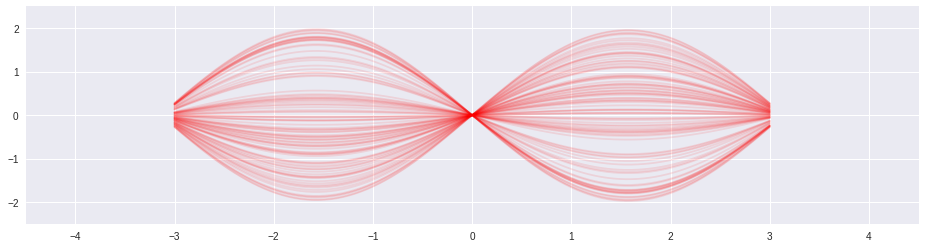

In [0]:
#@title Plot Training Datasets (Context and Target)
n_obs = 5
n_context = 5
xs = np.random.uniform(0, 3, n_obs)
amp = 1
ys = amp * np.sin(xs)
num_samples =100 #@param{type:'integer'}
x_star = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(1, figsize=(16,4))
for i in range(num_samples):
    y_temp = train_amp[i]*np.sin(x_star+train_phase[i])
    ax.plot(x_star, y_temp, c='red', alpha=0.1)
ax.set_xlim((-4.5, 4.5))
ax.set_ylim((-2.5, 2.5))
plt.show()

The plot above details the space spanned by the context set, used for training the Neural Process. In the above, the phase is fixed at 0, but the amplitude varies.

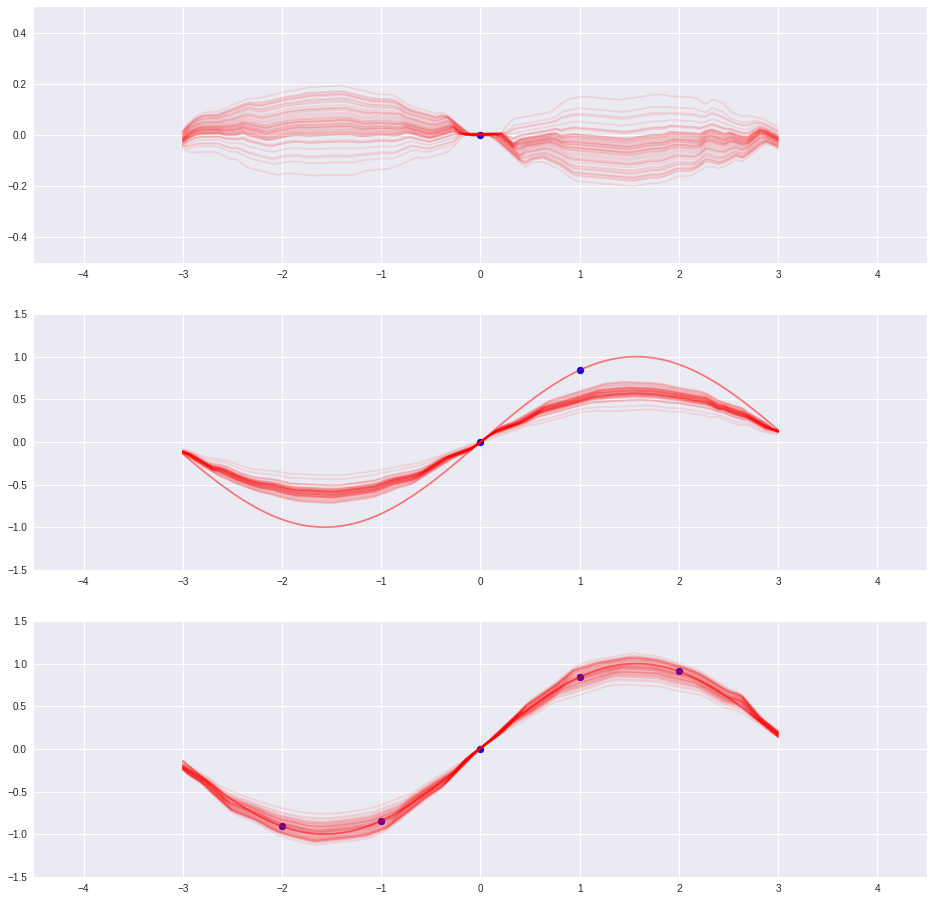

In [0]:
#@title Plot Predictions

AMPLITUDE = 1 #@param {type:"number"}
amp = AMPLITUDE
PHASE = 0 #@param {type:"number"}
phase = PHASE

#=========================================================
# PLOTTING PREDICTIONS

x_star = np.linspace(-3, 3, 100)
y_star = amp * np.sin(x_star+phase)

def plot_prediction(ax, xs, ys, x_star, y_star, plot_true = True, xlim = (-4.5, 4.5), ylim=(-1.5, 1.5)):
    posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)), 
        ys.reshape((-1,1)), 
        x_star.reshape((-1,1)), 
        params, n_draws=50)
    y_star_mat = sess.run(posterior_predict_op.mu)

    for i in range(y_star_mat.shape[1]):
        ax.plot(x_star, y_star_mat.T[i], c='red', alpha=0.1)
    if plot_true:
        ax.plot(x_star, y_star, c='red', alpha=.5)
    ax.scatter(xs, ys, c='blue')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, axes = plt.subplots(3, 1, figsize=(16,16))
xss = [np.array(xs) for xs in [[0], [0, 1], [-2, -1, 0, 1, 2]]]
yss = [amp*np.sin(xs+phase) for xs in xss]
plot_true = False
ylim=(-0.5, 0.5)
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim)
    plot_true = True
    ylim=(-1.5, 1.5)

The above plots show the mean predictions, decoded from the latent variable and test data points. The curves appear to fit the data as one would expect, even showing some attractive uncertainty quantification properties. However, note this is mean of predictions so does not include the variance, and hence not appropriate for a proper treatment of uncertainty quantification.

The first plot with a non-informative data point at the origin appears to resemble the context training plot, similar to a prior. The second plot shows how the process can take just two positive points and recover some of the negative side of the curve. With a spread of test observations, the Neural Process recovers the 'true' underlying sine curve well.

In [0]:
#@title Train on Sine Data Generator

tf.reset_default_graph()
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[8,8],
                             n_hidden_units_g=[32, 32, 32])
sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target, params, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 200000 #@param{type:'integer'}
loss_freq = 1e4

train_xs = []
train_amp = []
train_ys = []
train_phase = []
VARIABLE_PHASE = True #@param {type:"boolean"}
for i in range(n_iter):
    n_obs = 20
    xs = np.random.uniform(-3, 3, n_obs)
    amp = random.uniform(-2, 2)
    if VARIABLE_PHASE:
      phase = random.uniform(0, np.pi)
    else:
      phase = 0
      
    ys = amp * np.sin(xs+phase)
    
    train_xs.append(xs)
    train_amp.append(amp)
    train_ys.append(ys)
    train_phase.append(phase)
    
    n_context = random.choice(range(1, 11))
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target, y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    if i % loss_freq == 0:
        print("Loss: {:.3f}".format(a[1]))






Loss: -23.491
Loss: -23.457
Loss: 5852.907
Loss: 6240.423
Loss: 1498.688
Loss: 363.202
Loss: 1509.417
Loss: 60.159
Loss: 1656.926
Loss: 2621.431
Loss: 1623.742
Loss: 555.039
Loss: 1787.416
Loss: 913.630
Loss: 279.176
Loss: 1197.199
Loss: 3406.684
Loss: 2528.392
Loss: 5370.670
Loss: -6.669


The same experiment is now undertaken with varying phase. The plot below shows the space of functions observed in the context set for varying phase and amplitude.

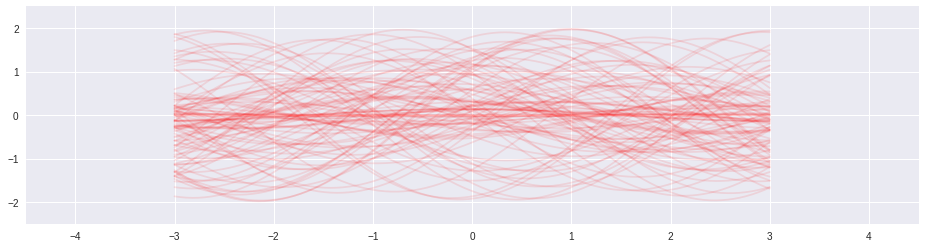

In [0]:

#@title Plot Training Datasets (Context and Target)
n_obs = 5
n_context = 5
xs = np.random.uniform(0, 3, n_obs)
amp = 1
ys = amp * np.sin(xs)
num_samples =100 #@param{type:'integer'}
x_star = np.linspace(-3, 3, 100)
y_star = amp * np.sin(x_star)

fig, ax = plt.subplots(1, figsize=(16,4))
for i in range(num_samples):
    y_temp = train_amp[i]*np.sin(x_star+train_phase[i])
    ax.plot(x_star, y_temp, c='red', alpha=0.1)
ax.set_xlim((-4.5, 4.5))
ax.set_ylim((-2.5, 2.5))
plt.show()

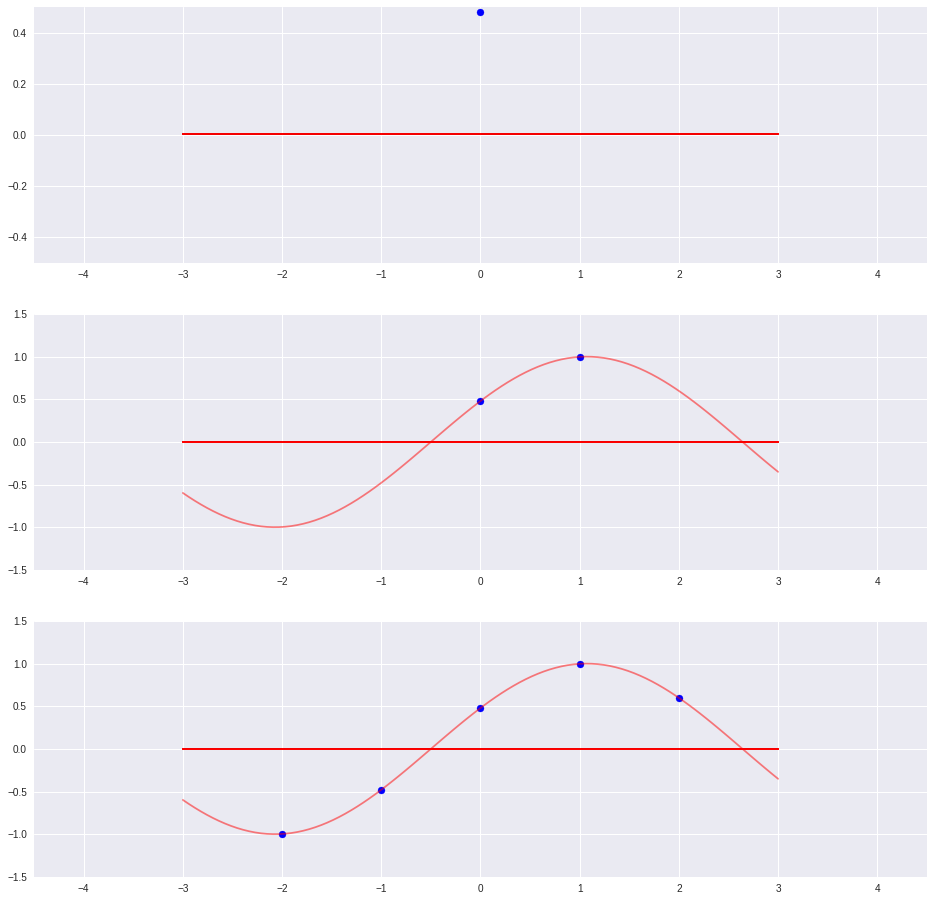

In [0]:
#@title Plot Predictions

AMPLITUDE = 1 #@param {type:"number"}
amp = AMPLITUDE
PHASE = 0.5 #@param {type:"number"}
phase = PHASE

#=========================================================
# PLOTTING PREDICTIONS

x_star = np.linspace(-3, 3, 100)
y_star = amp * np.sin(x_star+phase)

def plot_prediction(ax, xs, ys, x_star, y_star, plot_true = True, xlim = (-4.5, 4.5), ylim=(-1.5, 1.5)):
    posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)), 
        ys.reshape((-1,1)), 
        x_star.reshape((-1,1)), 
        params, n_draws=50)
    y_star_mat = sess.run(posterior_predict_op.mu)

    for i in range(y_star_mat.shape[1]):
        ax.plot(x_star, y_star_mat.T[i], c='red', alpha=0.1)
    if plot_true:
        ax.plot(x_star, y_star, c='red', alpha=.5)
    ax.scatter(xs, ys, c='blue')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, axes = plt.subplots(3, 1, figsize=(16,16))
xss = [np.array(xs) for xs in [[0], [0, 1], [-2, -1, 0, 1, 2]]]
yss = [amp*np.sin(xs+phase) for xs in xss]
plot_true = False
ylim=(-0.5, 0.5)
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim)
    plot_true = True
    ylim=(-1.5, 1.5)

The first plot does not show the same recovery of the context set as was seen with fixed phase, possibly due to insufficient training or insufficient complexity of the encoder/decoder architectures. The subsequent plots appear to recover the curves reasonably well however.

### Gaussian Processes

In this experiment, we will test how NP can be used to learn the distribution of tasks, where each task is a function sampled from the same GP with a Matern52 kernel with variance 2, length scale 1.5.

We sampled 20 such functions and for each task we sample 3 points randomly from it. The aim of the this experiment is to see whether the NP trained along with these 20 tasks can learn the common structure underlying these tasks (the kernel).

Here are the 20 samples from a Gaussian Process


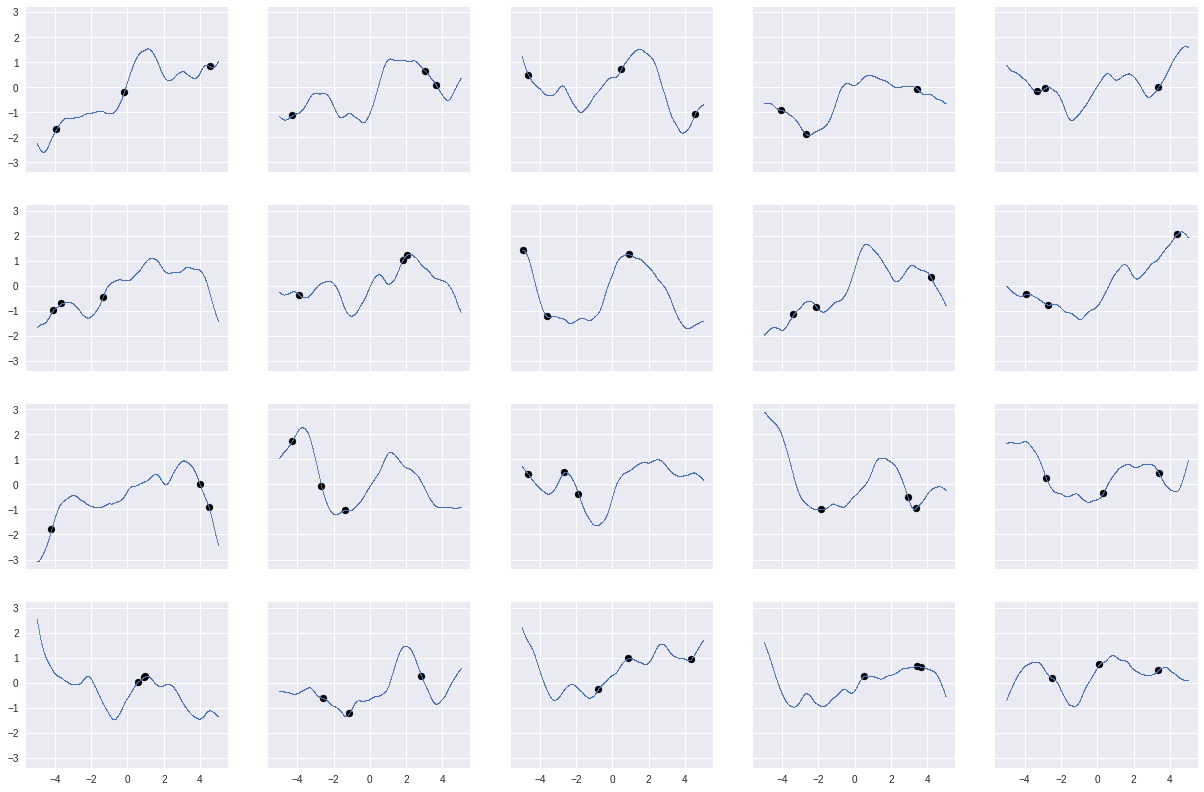

In [0]:
print("Here are the 20 samples from a Gaussian Process")
Image("../content/neural_processes/experiments/Alan/GP_exp1.png", width=1000)

We will be using a NP with the following setup,

* $h$, $g$ are both a 3 layer NN 
* The Z-encoder are both 1 layer NN

We willl also fit a Gaussian processes (with RBF + white noise kernel) to each of the separate tasks and compare to the NP. 

Below demonstrates the results,

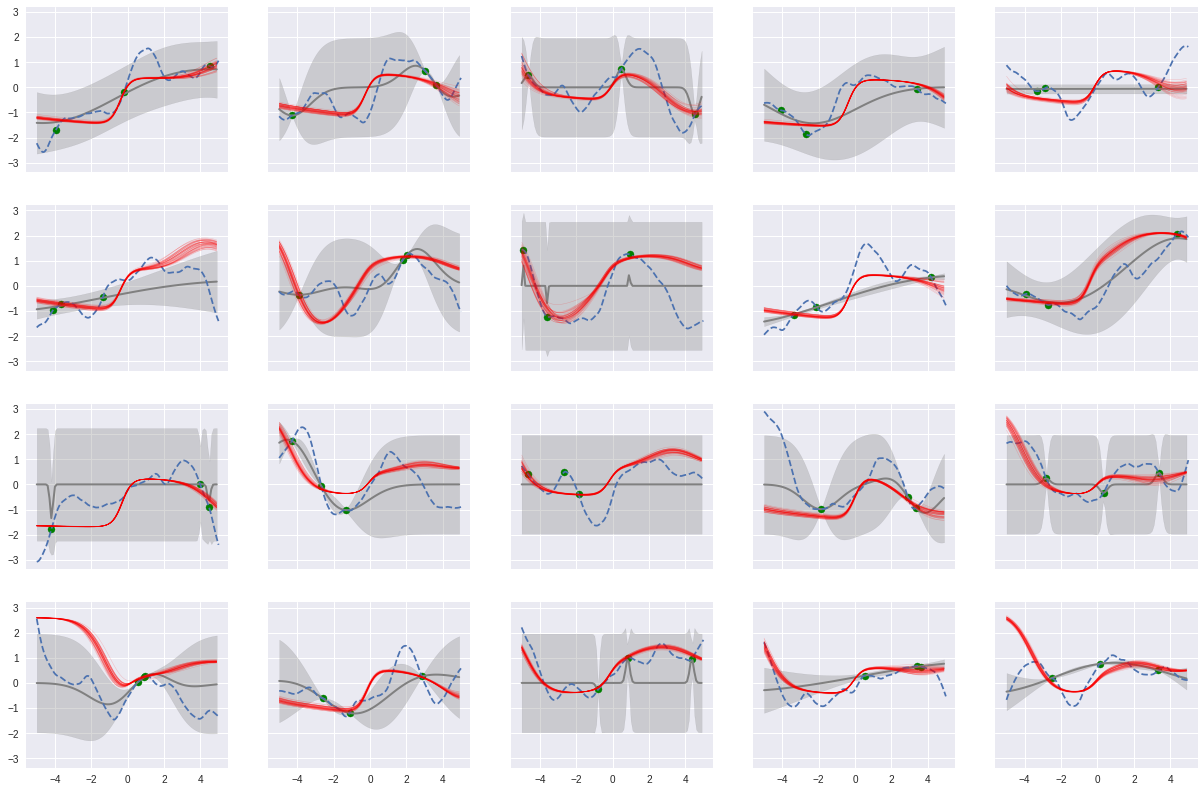

In [0]:
display(Image("../content/neural_processes/experiments/Alan/GP_exp2.png"))

Having a look at task 14, we see how the NP did learn the intrinsic structural information across the tasks.


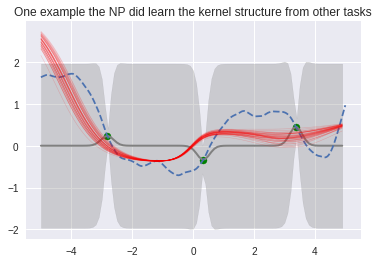

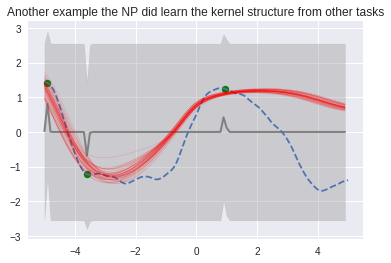

In [0]:
display(Image("../content/neural_processes/experiments/Alan/GP_exp3.png", height=300))
display(Image("../content/neural_processes/experiments/Alan/GP_exp4.png", height=300))

### Quadratic functions

The functions we consider in this section are of the form 
$$
f(x) = xQx^{T} + p
$$
and we take $x \in \mathbb{R}\;; Q, p \in \mathbb{R}, Q > 0$, resulting in convex parabolas. 

We generate observation sets to train the NP, by sampling $Q \sim \text{Unif}[5, 10], p \sim \text{Unif}[-2, 2]$, taking $x_i \sim \text{Unif}[-5, 5], i=1, ..., 100$, and forming $y_i  = f(x_i)$. To form the context set we sample $N$ randomly between 50 and 70. 

In [0]:
#@title Train on Quadratic Data Generator



#=========================================================
# INITIALISATION

# Initial setup
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[64, 64], n_hidden_units_g=[64, 64, 64])

tf.reset_default_graph()
sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target,
                                     params, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 200000 #@param {type:"integer"}
loss_freq = n_iter/10
n_obs = 100
q_low = 0.1
q_high = 10
p_low = -2
p_high = 2
x_range_low = -5
x_range_high = 5

#=========================================================
# TRAINING

train_xs = []
train_q = []
train_ys = []
train_p = []

for i in range(n_iter):
    xs = np.random.uniform(x_range_low, x_range_high, n_obs)
    q = random.uniform(q_low, q_high)
    p = random.uniform(p_low, p_high)
    ys = q * (xs)**2 + p

    train_xs.append(xs)
    train_q.append(q)
    train_p.append(p)
    train_ys.append(ys)

    n_context = random.choice(range(50,70))
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target,
                                     y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    if i % loss_freq == 0:
        print("Loss: {:.3f}".format(a[1]))

Loss: 14333221.000
Loss: 950276.875
Loss: 22230.701
Loss: 75944.172
Loss: 34019.484
Loss: 39012.727
Loss: 10653.374
Loss: 3871.336
Loss: 293352.406
Loss: 56329.375


(-25, 50)

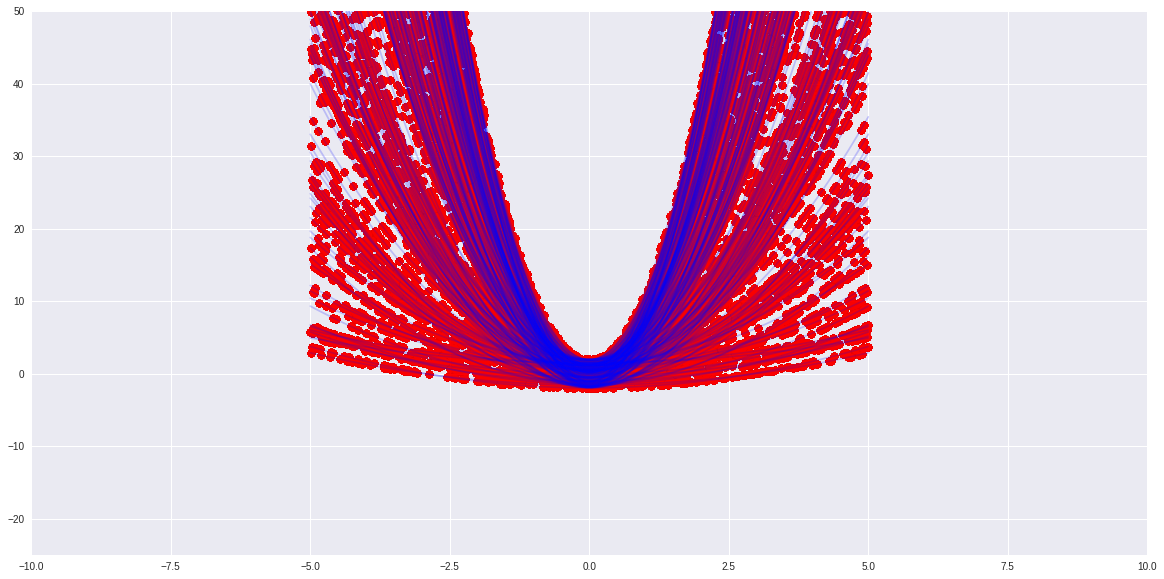

In [0]:
#@title Plot Training (Context and Target)
fig, ax = plt.subplots(1, figsize=(20,10))
n_samples = 100 #@param

n_samples = 200
x_star = np.linspace(-5, 5, 100)
for i in range(n_samples):
    y_temp = train_q[i]*x_star**2+train_p[i]
    ax.plot(x_star, y_temp, c='blue', alpha=0.2)
    ax.scatter(train_xs[:n_samples], train_ys[:n_samples], c='red', alpha=0.2)
ax.set_xlim((-10, 10))
ax.set_ylim((-25, 50))

The plot above shows the functions (in blue) and points (in red) that the NP was trained on. These appear to provide good coverage over the space with 200,000 iterations. 

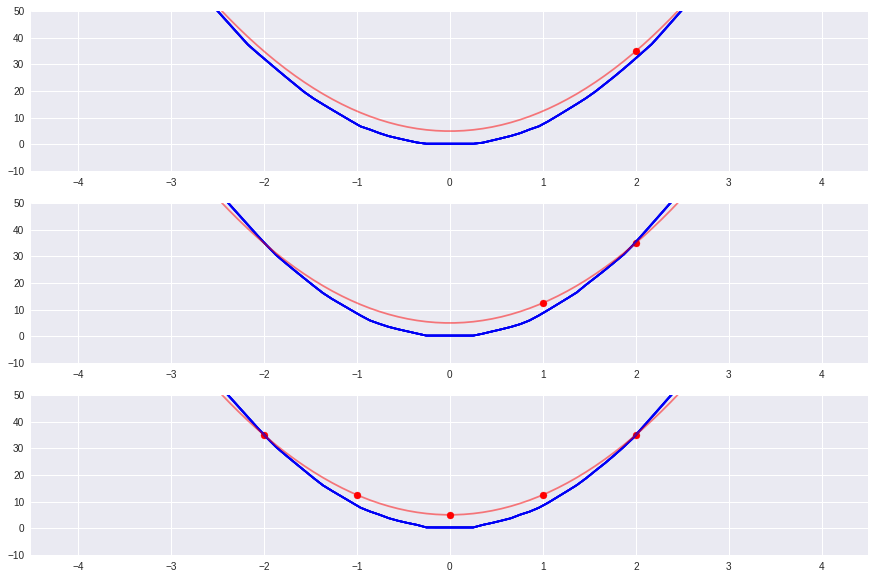

In [0]:
#@title Plot Predictions

X_SQUARED_COEFFICIENT = 7.5  #@param {type:"number"}
q_pred = X_SQUARED_COEFFICIENT
Y_INTERCEPT = 5 #@param {type:"number"}
p_pred = Y_INTERCEPT

#=========================================================
# PLOTTING PREDICTIONS

xs = np.random.uniform(x_range_low, x_range_high, 5)
ys = q_pred * (xs)**2 + p_pred
x_star = np.linspace(x_range_low, x_range_high, 100)
y_star = q_pred * (x_star)**2 + p_pred

def plot_prediction(ax, xs, ys, x_star, y_star, plot_true = True, xlim = (-4.5, 4.5), ylim=(-1.5, 1.5), sess= tf.get_default_session()):
    posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)),
        ys.reshape((-1,1)),
        x_star.reshape((-1,1)),
        params, n_draws=50)
    y_star_mat = sess.run(posterior_predict_op.mu)

    for i in range(y_star_mat.shape[1]):
        ax.plot(x_star, y_star_mat.T[i], c='b', alpha=0.1)
    if plot_true:
        ax.plot(x_star, y_star, c='r', alpha=.5)
    ax.scatter(xs, ys, c='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, axes = plt.subplots(3, 1, figsize=(15,10))
xss = [np.array(xs) for xs in [[2], [1, 2], [-2, -1, 0, 1, 2]]]
yss = [q_pred * (xs)**2 + p_pred for xs in xss]
plot_true = False
ylim=(-10, 50)
plot_true = True
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim, sess=sess)
    ylim=(-10, 50)
plt.show()


The plots show the mean NP predictions as blue lines, and observed points as red dots. The top plot shows the results with just one observed point. It is notable that although the blue lines form a shape close to the true test function, the uncertainty quantification appears to be poor - there are a large number of possible curves given the observation, but this is not well demonstrated by the predictions. The second plot demonstrates a good fit when two observation points are given. In the bottom plot, the three points fully determine the test function; the NP predictions are very similar to the case with two observations. 

Varying the $Q$ and $p$ parameters in the test function outside of the range seen during training results in much worse accuracy of the predictions. It should also be noted that the results appear to vary greatly depending on the choice of the number of iterations, the number of observations used at each iteration, the dimension of $r$ and $z$ and the number of layers in the NNs $h$ and $g$. Unfortunate choices result in very inaccurate predictions, with the samples poorly resembling the test function; the NP requires careful tuning. 

### 3-Degree Polynomials

We build on the previous experiment and look at the performance of NPs in predicting polynomial functions of the form
$f(x) = \beta_0 + \beta_1  x + \beta_2 x^2 + \beta_3 x^3$
where each $\beta_p$ is 0 with probability $\phi$, and $\mathcal{N}(0, I)$ with probability $(1-\phi)$.  Therefore the family of functions is quite vast, including linear, quadratic and cubic functions.


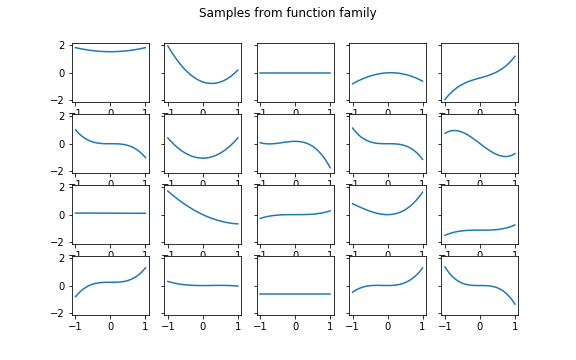

In [0]:
display(Image("../content/neural_processes/experiments/valerie/figs/poly_family.png", height=300))

The model was trained using a separate [NP implementation](https://github.com/JTT94/neural_processes/blob/master/experiments/valerie/NeuralProcess_vb.ipynb) (also based largely on [Kaspar Martens' tutorial](https://kasparmartens.rbind.io/post/np/) and [Sander van Dijk's Python implementation](https://github.com/sgvandijk/neural-processes)).

#### Model parameters
The NP was trained with $r$ and $z$ each of dimension 4. The encoder $h$ ($(x_i, y_i) \rightarrow r_i$) had 3 hidden layers with widths: 64, 32 and 32, respectively.  The decoder $g$ ($(x^*, z) \rightarrow y^*$) had 3 hidden layers of widths: 32, 64 and 32 respectively.   On each of 200k iterations:


1.   Sample $x_i \sim \mathcal{U}(-3,3)$ iid for $i=1,\dots,50$
2.   Sample $$\beta_p \sim 
\begin{cases}
\mathcal{N}(0,1) \qquad \text{with prob } (1-\phi)\\\
0\qquad\qquad \text{with prob } \phi
\end{cases}
$$ iid for $p=0,\dots,3$
3.   Calculate $y = f(x)$ using sampled $\mathbf{x}$ and $\beta_p$s
4.   Select number of context points uniformly from $[1,25]$ and randomly allocate $(x_i,y_i)$ pairs to context or target sets
5.   Perform optimization step, minimizing ELBO


#### Results
The plots below each show 25 draws from the posterior distribution (in blue) using 5, 10, 50 or 100 context points from a function from our family of distributions.  The model was fit in 500k iterations. The context points are shown in orange.  The cubic function is well estimated by the model, even when only supplied with 10 context points.  The linear and quadratic functions are not as well estimated, though it's important to note the scale on which each function was plotted - the smaller scale on the y-axis for the linear and quadratic functions help to emphasize the errors and non-smoothness in the posterior samples.

We believe that the cubic function is best estimated by this model due to the overrepresentation in our training dat due to the way we generated the family of functions.  We will address this in the next experiement.



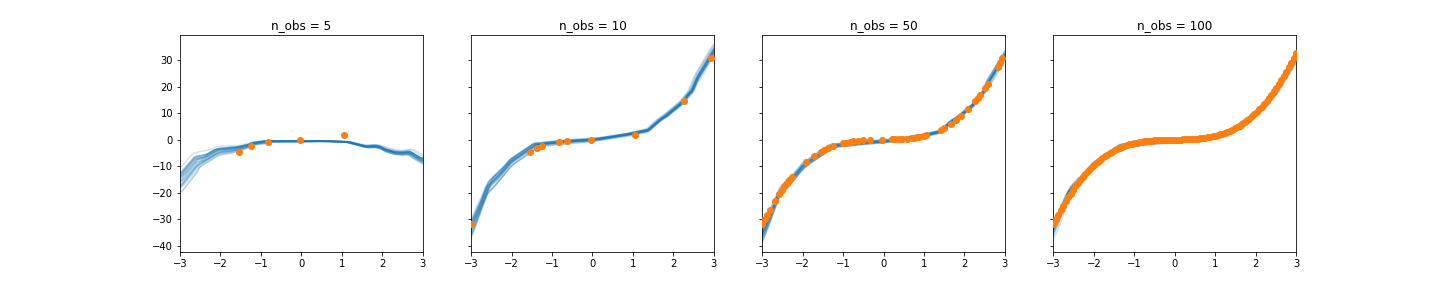

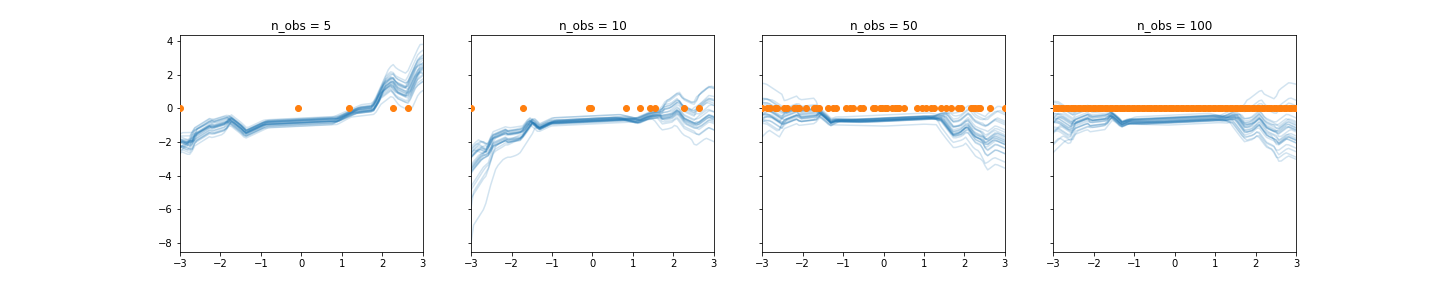

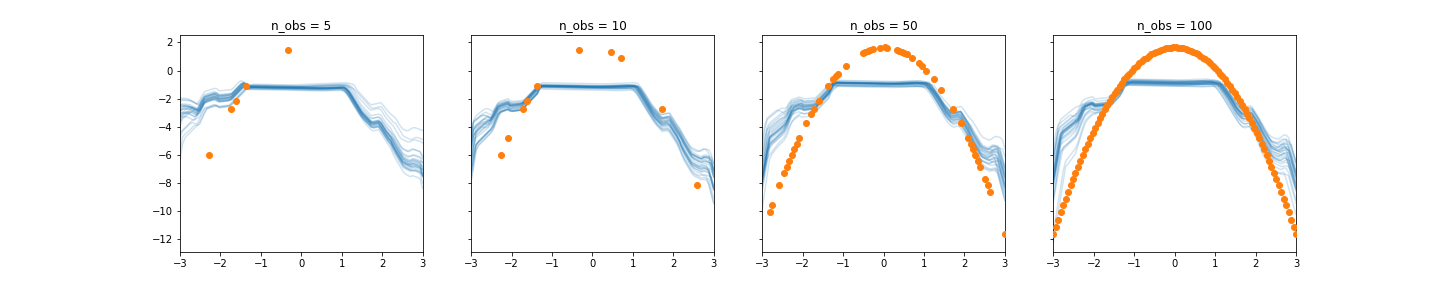

In [0]:
display(Image("../content/neural_processes/experiments/valerie/figs/iter500dim4/poly_ex0.png", height=150))
display(Image("../content/neural_processes/experiments/valerie/figs/iter500dim4/poly_ex5.png", height=150))
display(Image("../content/neural_processes/experiments/valerie/figs/iter500dim4/poly_ex9.png", height=150))

The plots below show the same model trained in fewer iterations - 200k and 400k, respectively.  The model is predicting the general shape of the cubic functions, but the fit is nowhere as good as the model trained with 500k iterations.  The model is highly sensitive to the number of iterations used in training, and the number of iterations required for more complex examples increases rapidly.

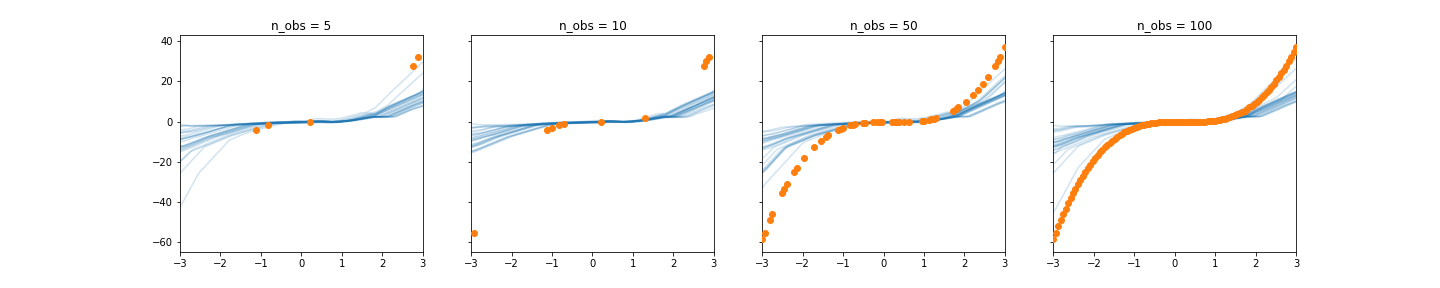

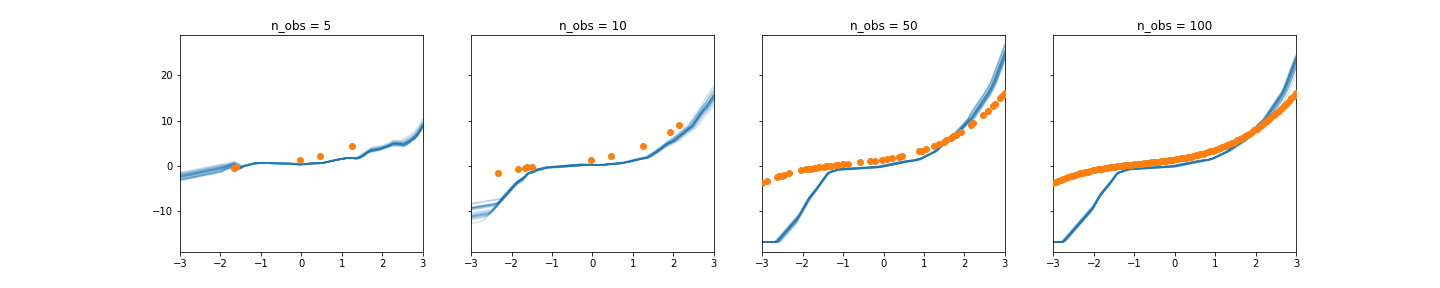

In [0]:
display(Image("../content/neural_processes/experiments/valerie/figs/iter200dim4/poly_ex3.png", height=150))
display(Image("../content/neural_processes/experiments/valerie/figs/iter400dim4/poly_ex4.png", height=150))

## 5-Degree Polynomials

We repeated the experiment above for a larger family of polynomials of the form $f(x) = \beta_0 + \beta_1  x + \beta_2 x^2 + \beta_3 x^3 + \beta_4x^4 \beta_5 x^5$.  We observed in the previous experiment that with $\phi = 0.5$, our training set was dominated by cubic polynomials, which improved the fit for the higher-order functions.  In this experiment, we set $\phi = 0.25$, so the training set would not be as dominated by the highest-order functions.  A plot of 20 functions sampled from this family is shown below.

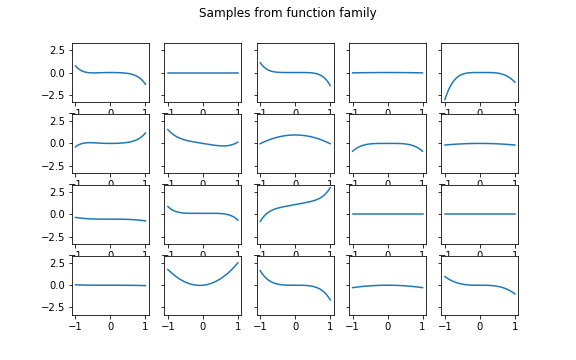

In [0]:
display(Image("../content/neural_processes/experiments/valerie/figs/poly_family5.png", height=300))

### Results

The plots below each show 25 draws from the posterior distribution (in blue) using 5, 10, 50 or 100 context points from a function from our family of distributions. The model was fit in 600k iterations. The context points are shown in orange.  The posterior distributions seem to overestimate the complexity of the underlying functions.  For example, in the second figure below shows a linear function that the model is estimating as quadratic.  This could perhaps be fixed with additional iterations of the training procedure or more careful tuning of the underlying NN, however we did not have time to explore that here.


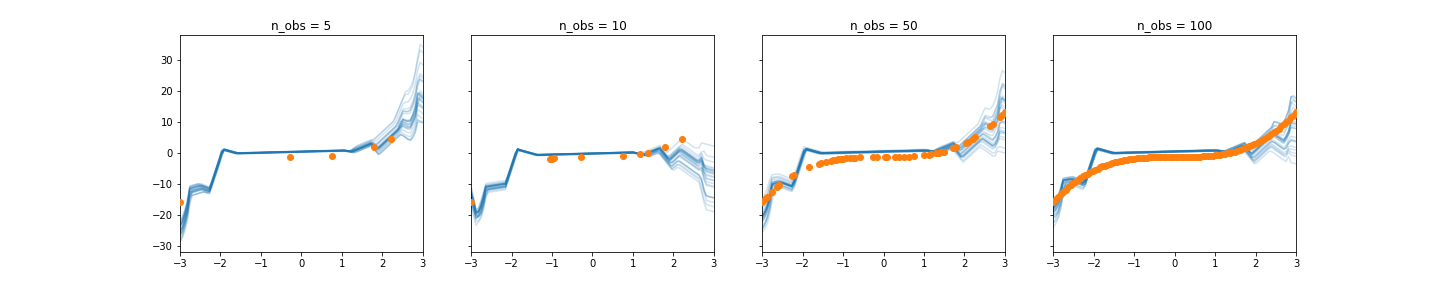

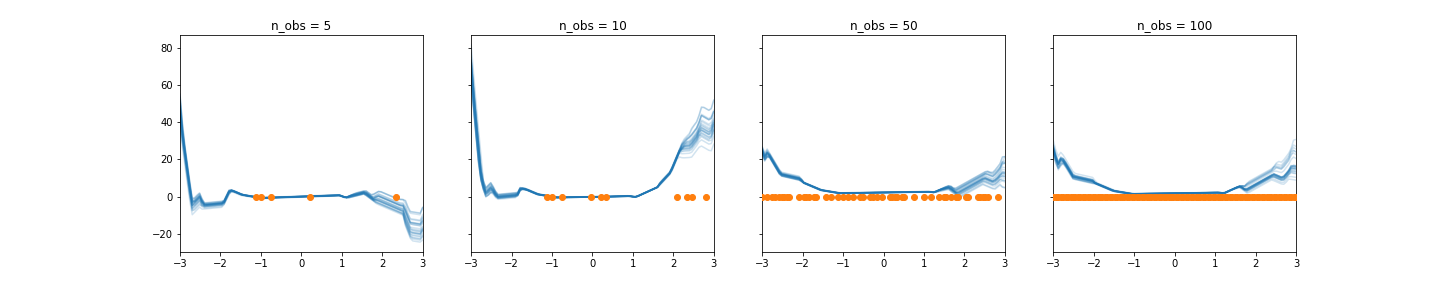

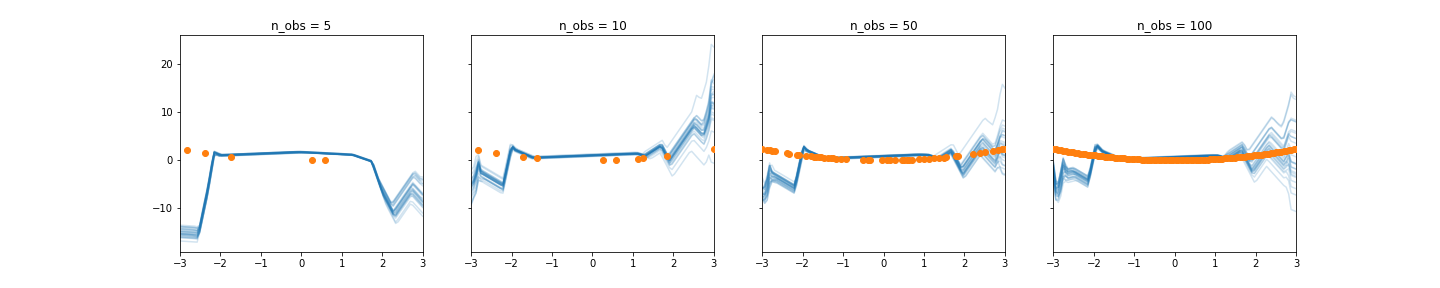

In [0]:
display(Image("../content/neural_processes/experiments/valerie/figs/iter600dim4deg5/poly_ex0.png", height=150))
display(Image("../content/neural_processes/experiments/valerie/figs/iter600dim4deg5/poly_ex3.png", height=150))
display(Image("../content/neural_processes/experiments/valerie/figs/iter600dim4deg5/poly_ex6.png", height=150))

## MAML and Conditional Neural Processes (CNP)

To explore how MAML is both general and performant, we apply it to Conditional Neural Processes (CNP) for a meta learning experiment. Recall CNP are deterministic counterparts to Neural Processes, therefore satisfy the gradient descent requirement of MAML.

Although further investigation is required to understand the relative benefits compared to regular CNP training, the procedure does appear to perform well in the same meta-learning setting detailed above.

Below, MAML-CNPs are trained using a Gaussian Process data generator for context data. The code below was taken by combining the CNP implementation by [Deep Mind](https://github.com/deepmind/neural-processes) and MAML implementation by [Finn](https://github.com/cbfinn/maml).

In [0]:
#@title CNP-MAML
import tensorflow as tf
from src.conditional_neural_process.gp_data_generator import GPCurvesReader
from src.conditional_neural_process.model import DeterministicModel

# Config
#------------------------------------------------------------
TRAINING_ITERATIONS = int(1000) #@param
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)
tf.reset_default_graph()

# Data
#------------------------------------------------------------
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()


dataset_train_task_level = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS)
data_task_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

# Model
#------------------------------------------------------------
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Define the model
def loss_fn(context_x, context_y, target_x, target_y, encoder_weights, decoder_weights):
  # Pass query through the encoder and the decoder
  representation = model.encoder(context_x, context_y, data_task_train.num_context_points, weights=encoder_weights)
  dist, mu, sigma = model.decoder(representation, target_x, data_task_train.num_total_points, weights=decoder_weights)

  log_p = dist.log_prob(target_y)
  loss = -tf.reduce_mean(log_p)
  return loss

def update_weights(loss, weights, update_lr = 0.2):
  grads = tf.gradients(loss, list(weights.values()))
  gradients = dict(zip(weights.keys(), grads))
  fast_weights = dict(zip(weights.keys(), [weights[key] - update_lr*gradients[key] for key in weights.keys()]))
  return fast_weights

model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)
# Hack to initialise weights
_, _, _ = model(data_train.query, data_train.num_total_points,
                       data_train.num_context_points, data_train.target_y)

lossesb = []
batch_size = 10
encoder_weights = model.encoder.weights
decoder_weights = model.decoder.weights
for i in range(batch_size):
  (context_x, context_y), target_x = data_task_train.query
  target_y = data_task_train.target_y

  lossa = loss_fn(context_x, context_y, target_x, target_y, encoder_weights, decoder_weights)

  new_encoder_weights = update_weights(lossa, encoder_weights, update_lr = 0.2)
  new_decoder_weights = update_weights(lossa, decoder_weights, update_lr = 0.2)

  (context_xb, context_yb), target_xb = data_task_train.query
  target_yb = data_task_train.target_y
  lossb = loss_fn(context_xb, context_yb, target_xb, target_yb, new_encoder_weights, new_decoder_weights)
  lossesb.append(lossb)



total_loss_b = tf.reduce_sum(lossesb)
optimizer = tf.train.AdamOptimizer(0.2)
gvs = optimizer.compute_gradients(total_loss_b)
metatrain_op = optimizer.apply_gradients(gvs)


# Training loop
#------------------------------------------------------------

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
preds = []
xs = []
ys =[]
for it in range(TRAINING_ITERATIONS):
  sess.run([metatrain_op])
  print(it)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The T

![](https://raw.githubusercontent.com/JTT94/neural_processes/master/docs/cnp_gp.png)

Based on the figure above, it can be seen that the MAML-CNP mean prediction (blue) provides a reasonable closeness to the test points (black), note that these points were not used in the context/target training procedure. Note also that the light blue shaded region indicates the bounds with one standard deviation tolerance of the prediction points, hence gives an indication of uncertainty. Gaussian Processes are non-identifiable from a finite realisation, so some aspect of closeness, prior to fine-tuning is performant. 



# Discussion


Neural Processes were used to perform regression tasks on a variety of distributions over functions, including Gaussian Processes, distributions over sine curves, quadratic functions and a broad class of polynomial functions.


Broadly, it can be seen that NPs perform well for learning highly structured classes of functions with few layers in the encoder, decoder architectures. In all of the experiments above, we observed high sensitivity of the NP to the underlying neural network architecture, specifically the number and width of the hidden layers in the encoder and decoder multi-layer perceptrons, and the dimensions of latent variables $r$ and $z$.  As we increased the complexity of the function class used in training, more iterations and more sophisticated network architectures were required to achieve visually reasonable results. 


In the polynomial experiment, we observed numerical instability in the optimization step - the loss function could not be evaluated - when the dimensions of $r$ and $z$ were greater than 4. Additionally, all of our underlying neural networks relied primarily on ReLU layers, which we think led to the insufficiently smooth predictions, particularly when the NPs were not trained with enough iterations.  Further research is needed on best practices for fitting Neural Processes, particularly on the sensitivity of NPs to dimensions of $r$ and $z$. We believe there is a complex and unclear relationship between the training procedure, complexity of the networks and under/over fit. To the best of our knowledge, architecture is often chosen in practice via experimentation and intuition.


Unsurprisingly, we consistently observed increased model accuracy as the number of training iterations increased, particularly for more complex functions or larger families of functions.  However, we were not able to develop best practices for estimating the number of iterations required for types of probelems.


In terms of future work, it would be interesting to explore the uncertainty quantification properties of Neural Processes, given their probabilistic interpretation. It would also be interesting to apply these types of models to less structured classes of functions such as images and text classification. Exploring MAML's comparison to NPs at meta-learning and quantifying benefits would be a natural next step to this report, excluded only due to time constraints.

# References



* Finn, Chelsea, Pieter Abbeel, and Sergey Levine. "[Model-agnostic meta-learning for fast adaptation of deep networks.](https://arxiv.org/abs/1703.03400)" Proceedings of the 34th International Conference on Machine Learning-Volume 70. JMLR. org, 2017. 
*   Garnelo, Marta, et al. "[Neural processes](https://arxiv.org/abs/1807.01622)." arXiv preprint arXiv:1807.01622 (2018)
*   Garnelo, Marta, et al. "[Conditional neural processes](https://arxiv.org/abs/1807.01613)." arXiv preprint arXiv:1807.01613 (2018).
*   Kim, Hyunjik, et al. "[Attentive Neural Processes](https://arxiv.org/abs/1901.05761)." arXiv preprint arXiv:1901.05761 (2019).
*   Martens, Kaspar.  "Neural Processes as distributions over functions." 10 Aug 2018. [kasparmartens.rbind.io/post/np/](https://kasparmartens.rbind.io/post/np/).
*   Van Dijk, S. "neural-processes." 10 Nov 2018. GiitHub Repository. [https://github.com/sgvandijk/neural-processes](https://github.com/sgvandijk/neural-processes).


